In [1]:
## Import libraries
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import time
import pathlib
import pylab as pl
from IPython import display

In [2]:
#Set data directory
data_dir = "../input/impressionistlandscapespaintings/content/drive/MyDrive/impressionist_landscapes_resized_1024"
data_dir = pathlib.Path(data_dir)

In [3]:
def get_dataset(data_dir, dim, seed=None, batch_size=32):
    '''get dataset with specified image dimensions'''
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        seed=seed,
        image_size=(dim, dim),
        batch_size=batch_size,
        shuffle=True,
        label_mode=None)
    
    return train_ds

In [4]:
def get_scaled_dataset(ds, dim, cache=True):
    '''resizes images and normalizes pixel values to [-1, 1]'''
    scaler = tf.keras.Sequential([
        tf.keras.layers.Resizing(height=dim, width=dim, interpolation="bilinear"),
        tf.keras.layers.Rescaling(1./127.5, offset=-1)
    ])
    if cache:
        return ds.map(scaler).cache().prefetch(tf.data.AUTOTUNE)
    return ds.map(scaler).prefetch(tf.data.AUTOTUNE)

In [5]:
def plot_image(image):
    image = tf.keras.layers.Rescaling(scale=127.5, offset=127.5)(image)
    return plt.imshow(image.numpy().astype("int16"))
    
def sample_image(model, seed=None):
    '''gets image from generator with random noise as seed'''
    noise = tf.random.normal([1, 100], seed=seed)
    image = model(noise, training=False)
    plot = plot_image(image[0])
    return plot

In [6]:
#Make WeightedSum layer by subclassing Add layer
class WeightedSum(tf.keras.layers.Add):
    def __init__(self, alpha=0.0, **kwargs):
        super(WeightedSum, self).__init__(**kwargs)
        self.alpha = tf.keras.backend.variable(alpha, name='ws_alpha')
    def _merge_functions(self, inputs):
        assert len(inputs) == 2
        res = ((1.0 - self.alpha) * inputs[0]) + self.alpha * inputs[1]
        return res

In [7]:
#Discriminator
def add_discrim_block(base_model, n_input_layers=3):
    base_input_shape = list(base_model.input_shape)
    input_shape = (base_input_shape[-2] * 2, base_input_shape[-2] * 2, base_input_shape[-1])
    
    #new input layer
    #discriminator needs a new input layer as the new model will take in larger inputs
    input0 = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(input0)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    #new block
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.AveragePooling2D()(x)
    new_block = x #keep for skip connection
    
    for i in range(n_input_layers, len(base_model.layers)):
        x = base_model.layers[i](x)
    #get model without skip connection
    model1 = tf.keras.Model(inputs=[input0], outputs=[x])
    
    #downsample so base model can still generate output with bigger new input
    downsample = tf.keras.layers.AveragePooling2D()(input0)
    base_block = base_model.layers[1](downsample)
    base_block = base_model.layers[2](base_block)
    
    x = WeightedSum()([base_block, new_block])
    
    for i in range(n_input_layers, len(base_model.layers)):
        x = base_model.layers[i](x)
    
    #get model with weighted skip connection
    model2 = tf.keras.Model(inputs=[input0], outputs=[x])
    return [model1, model2]

def get_discrim(input_shape=(4,4,3)):
    '''initialises base model'''
    input0 = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (1,1), padding='same', kernel_initializer='he_normal')(input0)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(128, (4,4), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    
    model = tf.keras.Model(inputs=[input0], outputs=[x])
    return model

In [8]:
def add_gen_block(base_model):
    base_end = base_model.layers[-2].output
    
    upsampling = tf.keras.layers.UpSampling2D()(base_end)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(upsampling)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    x = tf.keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    new_out = tf.keras.layers.Conv2D(3, (1,1), padding='same', kernel_initializer='he_normal')(x)
    
    model1 = tf.keras.Model(inputs=[base_model.input], outputs=[new_out])
    
    base_output_layer = base_model.layers[-1]
    base_out = base_output_layer(upsampling)
    
    merged = WeightedSum()([base_out, new_out])
    
    model2 = tf.keras.Model(inputs=[base_model.input], outputs=[merged])
    return [model1, model2]

def get_gen(latent_dim=100, indim=4):
    '''initialises base model'''
    channels = 512
    input0 = tf.keras.Input(shape=(latent_dim,))
    x = tf.keras.layers.Dense(512, kernel_initializer='he_normal')(input0)
    x = tf.keras.layers.Reshape((4,4,32))(x)
    
    x = tf.keras.layers.Conv2D(channels, (4,4), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    x = tf.keras.layers.Conv2D(channels, (3,3), padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    
    out = tf.keras.layers.Conv2D(3, (1,1), padding='same', kernel_initializer='he_normal', activation='tanh')(x)
    
    model = tf.keras.Model(inputs=[input0], outputs=[out])
    return model

In [9]:
def update_fadein(model, step, n_step):
    alpha = step / float(n_step-1)
    for layer in model.layers:
        if isinstance(layer, WeightedSum):
            tf.keras.backend.set_value(layer.alpha, alpha)

In [10]:
cep = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cep(tf.ones_like(real_output), real_output)
    fake_loss = cep(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cep(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.99, epsilon=10e-8)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0, beta_2=0.99, epsilon=10e-8)

In [11]:
def train(dataset, epochs):
    for epoch in range(epochs):
        update_fadein(generator, epoch, epochs)
        update_fadein(discriminator, epoch, epochs)
        
        start = time.time()
        total_gen_loss = 0
        total_disc_loss = 0
        batch_i = 0
        
        for i, batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            batch_i = i
            print(f"Batch {i} | time {time.time()-start:03.2f}s | gen_loss = {total_gen_loss/(i+1):00.4f} | disc_loss = {total_disc_loss/(i+1):00.4f}", end='\r')
            
        display.clear_output(wait=True)
        display.display(pl.gcf())
        print(f"Time for epoch {epoch+1} was {time.time()-start:03.2f}s | gen_loss = {total_gen_loss/(batch_i+1):00.4f} | disc_loss = {total_disc_loss/(batch_i+1):00.4f}")
        sample_image(generator, seed=378)
        plt.show()

In [12]:
epochs = 300
noise_dim = 100
batch_size = 16

<Figure size 432x288 with 0 Axes>

Time for epoch 300 was 37.58s | gen_loss = 2.8979 | disc_loss = 0.4654


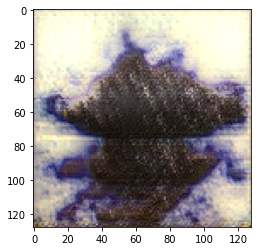

In [13]:
generator = get_gen()
discriminator = get_discrim()
straight_through_g = generator
straight_through_d = discriminator
augmentation = tf.keras.Sequential([
    tf.keras.layers.GaussianNoise(25),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
])
dataset = get_dataset(data_dir, dim=128, batch_size=batch_size)

dim = 4
for i in range(6):
    cache = dim <= 256
    train_ds = get_scaled_dataset(dataset, dim)
    @tf.function
    def train_step(images):
        noise=tf.random.normal([batch_size, noise_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            gen_img = generator(noise, training=True)

            real_output = discriminator(augmentation(images), training=True)
            fake_output = discriminator(augmentation(gen_img), training=True)

            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)

        grad_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(grad_gen, generator.trainable_variables))
        
        if disc_loss >= 0.3:
            grad_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)   
            discriminator_optimizer.apply_gradients(zip(grad_disc, discriminator.trainable_variables))

        return gen_loss, disc_loss
    train(train_ds, epochs)
    
    
    if i < 5:
        straight_through_g, generator = add_gen_block(straight_through_g)
        straight_through_d, discriminator = add_discrim_block(straight_through_d)
        dim *= 2

In [14]:
!mkdir output

In [15]:
rescale_layer = tf.keras.layers.Rescaling(scale=127.5, offset=127.5)
for i in range(1000):
    noise = tf.random.normal([1, 100])
    img = generator(noise)
    img = rescale_layer(img)
    res = PIL.Image.fromarray(img.numpy().astype(np.uint8)[0])
    res.save(f'./output/{i}.png')

In [16]:
straight_through_g.save('Generator')

2022-02-27 18:48:04.875469: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
